In [1]:
'''
In this file, we train a model which we will susequently reason with to explain superposition over ambiguity and different interpretations of ambiguous sentences 
'''

# import all sorts of stuff 
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq.backend.drawing import draw
import matplotlib.pyplot as plt
import matplotlib
from lambeq import AtomicType

# optimising the diagram to make the resulting quanutm circuit less complex
from lambeq import RemoveSwapsRewriter, RemoveCupsRewriter
from lambeq import Rewriter 

# creating the quantum circuit
from lambeq import IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

import numpy as np

# amplitude Encoding
from qiskit import QuantumCircuit

/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
import numpy as np

BATCH_SIZE = 10

SEED = 2

LEARNING_RATE = 3e-2


In [3]:
sentenceWithLabel = []

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
            sentenceWithLabel.append((line[1:].strip(), [t, 1-t]))
    return sentenceWithLabel

import random 



def train_test_split(data, test_size=0.2):

    random.shuffle(data)
    # Split the data into training and testing sets
    split_index = int(len(data) * (1 - test_size))
    train_data = data[:split_index]
    test_data = data[split_index:]
    return train_data, test_data

# note that words labelled with '1', receive the label  |0> = [1,0]

data = read_data('../datasets/newDataset/animalsVerbs.txt')
trainData, testData = train_test_split(data)

print(trainData)

train_labels = []
trainSentences = []
for i in range(len(trainData)):
    sent, lab = trainData[i]
    train_labels.append(lab)
    trainSentences.append(sent)

test_labels = []
testSentences = []
for i in range(len(trainData)):
    sent, lab = trainData[i]
    test_labels.append(lab)
    testSentences.append(sent)

# print(sentences)

print(testSentences)



[('bear screams', [1, 0]), ('giraffe hide', [0, 1]), ('giraffe hunts spider', [1, 0]), ('lion hunts giraffe', [1, 0]), ('lion screams', [0, 1]), ('cat dominates', [0, 1]), ('spider yells', [0, 1]), ('cat hunts giraffe', [0, 1]), ('dog hunts cat', [1, 0]), ('giraffe yells', [1, 0]), ('lion hunts cat', [1, 0]), ('lion yell', [0, 1]), ('giraffe runs', [1, 0]), ('spider scream', [0, 1]), ('cat hides', [1, 0]), ('cat scares', [0, 1]), ('cat hunts dog', [0, 1]), ('giraffe hunts cat', [1, 0]), ('bear hunts giraffe', [1, 0]), ('lion dominates', [1, 0]), ('cat hunts lion', [0, 1]), ('spider hunts cat', [0, 1]), ('lion hide', [0, 1]), ('bear dominates', [1, 0]), ('giraffe hunts dog', [1, 0]), ('lion hunts spider', [1, 0]), ('dog hunts lion', [0, 1]), ('spider hunts giraffe', [0, 1]), ('spider hunts bear', [0, 1]), ('bear hunts cat', [1, 0]), ('cat hunts spider', [1, 0]), ('bear hunts lion', [1, 0]), ('spider hunts lion', [0, 1]), ('bear hunts dog', [1, 0]), ('dog dominate', [0, 1]), ('dog yells'

In [4]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(trainSentences, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(testSentences, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [5]:
# normalising 

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

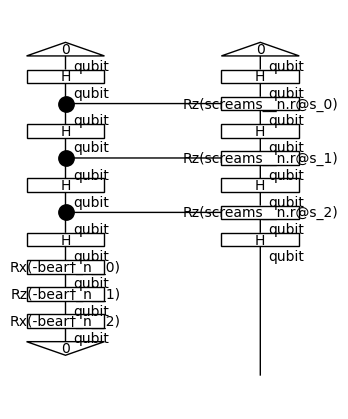

In [6]:
# create quantum circuits

from lambeq import AtomicType, IQPAnsatz

# choose IQP ansatz with one qubit each and 2 layers I gues 
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=3, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(3,4))

In [7]:
from lambeq import Dataset

all_circuits = train_circuits + test_circuits

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)
                          
test_dataset = Dataset(test_circuits, test_labels)



In [17]:
'''
Same thing, but for Tket model 
'''

EPOCHS = 150


from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

modelTK = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bceTK = BinaryCrossEntropyLoss()

accTK = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metricsTK = {"acc": accTK}

from lambeq import QuantumTrainer, SPSAOptimizer

trainerTK = QuantumTrainer(
    modelTK,
    loss_function=bceTK,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metricsTK,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)


trainerTK.fit(train_dataset, test_dataset)#, early_stopping_interval=10)

Epoch 1:    train/loss: 1.0017   valid/loss: 1.5010   train/acc: 0.5577   valid/acc: 0.4808
Epoch 2:    train/loss: 0.8111   valid/loss: 1.4505   train/acc: 0.3846   valid/acc: 0.4808
Epoch 3:    train/loss: 1.0328   valid/loss: 1.2046   train/acc: 0.5385   valid/acc: 0.4808
Epoch 4:    train/loss: 1.7159   valid/loss: 1.4729   train/acc: 0.5000   valid/acc: 0.4423
Epoch 5:    train/loss: 0.7066   valid/loss: 1.7847   train/acc: 0.5385   valid/acc: 0.4423
Epoch 6:    train/loss: 0.8259   valid/loss: 1.0509   train/acc: 0.4615   valid/acc: 0.4231
Epoch 7:    train/loss: 0.4559   valid/loss: 1.4401   train/acc: 0.4231   valid/acc: 0.5192
Epoch 8:    train/loss: 1.2406   valid/loss: 0.9204   train/acc: 0.4808   valid/acc: 0.4808
Epoch 9:    train/loss: 2.4521   valid/loss: 1.4211   train/acc: 0.5577   valid/acc: 0.5769
Epoch 10:   train/loss: 1.8975   valid/loss: 0.7837   train/acc: 0.5577   valid/acc: 0.5385
Epoch 11:   train/loss: 1.0620   valid/loss: 0.7353   train/acc: 0.5192   valid/

: 

Validation accuracy: 0.7403846153846154


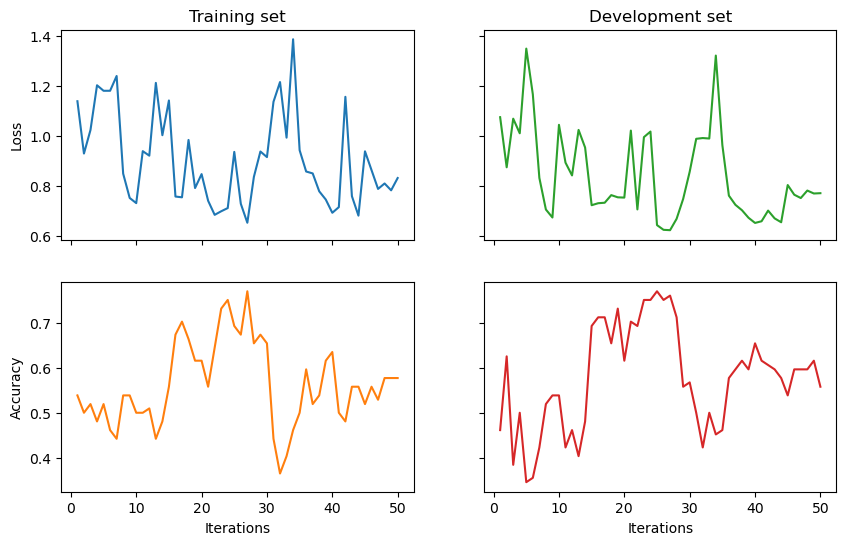

In [ ]:
import matplotlib.pyplot as plt

trainer = trainerTK
model = modelTK
acc = accTK
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
# pred = model(test_circuits)
# labels = torch.tensor(test_labels)


# print('Final test accuracy: {}'.format(acc(pred, labels)))

# print test accuracy - tket
modelTK.load(trainerTK.log_dir + '/best_model.lt')
val_acc = accTK(modelTK(test_circuits), test_labels)
print('Validation accuracy:', val_acc.item())

test_loss = BinaryCrossEntropyLoss()

In [ ]:
smbls = modelTK.symbols
# And the weights are their respective values 
weights = modelTK.weights

print(smbls)


[bear__n@n.l_0, bear__n@n.l_1, bear__n@n.l_2, bear†_n__0, bear†_n__1, bear†_n__2, cat__n@n.l_0, cat__n@n.l_1, cat__n@n.l_2, cat†_n__0, cat†_n__1, cat†_n__2, dog__n@n.l_0, dog__n@n.l_1, dog__n@n.l_2, dog†_n__0, dog†_n__1, dog†_n__2, dominate__n.r@s_0, dominate__n.r@s_1, dominate__n.r@s_2, dominates__n.r@s_0, dominates__n.r@s_1, dominates__n.r@s_2, giraffe†_n__0, giraffe†_n__1, giraffe†_n__2, hide__n.r@s_0, hide__n.r@s_1, hide__n.r@s_2, hides__n.r@s_0, hides__n.r@s_1, hides__n.r@s_2, hide†_n__0, hide†_n__1, hide†_n__2, hunts__n.r@s@n.l_0, hunts__n.r@s@n.l_1, hunts__n.r@s@n.l_2, hunts__n.r@s@n.l_3, hunts__n.r@s@n.l_4, hunts__n.r@s@n.l_5, lion__n@n.l_0, lion__n@n.l_1, lion__n@n.l_2, lion†_n__0, lion†_n__1, lion†_n__2, runs__n.r@s_0, runs__n.r@s_1, runs__n.r@s_2, scares__n.r@s_0, scares__n.r@s_1, scares__n.r@s_2, scares†_n__0, scares†_n__1, scares†_n__2, screams__n.r@s_0, screams__n.r@s_1, screams__n.r@s_2, scream†_n__0, scream†_n__1, scream†_n__2, spider__n@n.l_0, spider__n@n.l_1, spider__

In [ ]:
import re 

def extract_word_and_number(strings):
    new_strings = []
    for s in strings:
        match = re.match(r'^([a-zA-Z]+).*?(\d+)$', str(s))
        # print(str(s))
        if match:
            new_strings.append(f"{match.group(1)}{match.group(2)}")
    return new_strings

newSmbls = extract_word_and_number(smbls)
# print(weights)

parameterDict = {}

for i in range(len(newSmbls)):
    parameterDict[newSmbls[i]] = weights[i]

print(parameterDict)


{'bear0': 1.1408738411456574, 'bear1': 1.1859531350591108, 'bear2': 0.08209794248299937, 'cat0': 0.1649980878905926, 'cat1': 0.4598148461949828, 'cat2': 0.34476868877710054, 'dog0': 0.8044744987517555, 'dog1': 0.4141340824473717, 'dog2': 1.2173507842926563, 'dominate0': 0.6021399582229452, 'dominate1': 0.7737489993610867, 'dominate2': 1.1949295294426898, 'dominates0': 0.34099733081969125, 'dominates1': 0.22726832789582663, 'dominates2': 0.07239746104924788, 'giraffe0': -0.04868916627301335, 'giraffe1': 0.6467285355246164, 'giraffe2': -1.322197128713487, 'hide0': 0.5135067499304535, 'hide1': -0.056213353809740754, 'hide2': 0.724086454552084, 'hides0': 0.5087281180619416, 'hides1': 0.5941399070164965, 'hides2': 0.623410063607603, 'hunts0': 0.5288950915058581, 'hunts1': 0.09338324571824205, 'hunts2': 1.4061890367661396, 'hunts3': 1.913320900863796, 'hunts4': -0.496089708704284, 'hunts5': 0.825389121572287, 'lion0': 1.730181252897772, 'lion1': 0.8682007175978586, 'lion2': 0.415426511751687

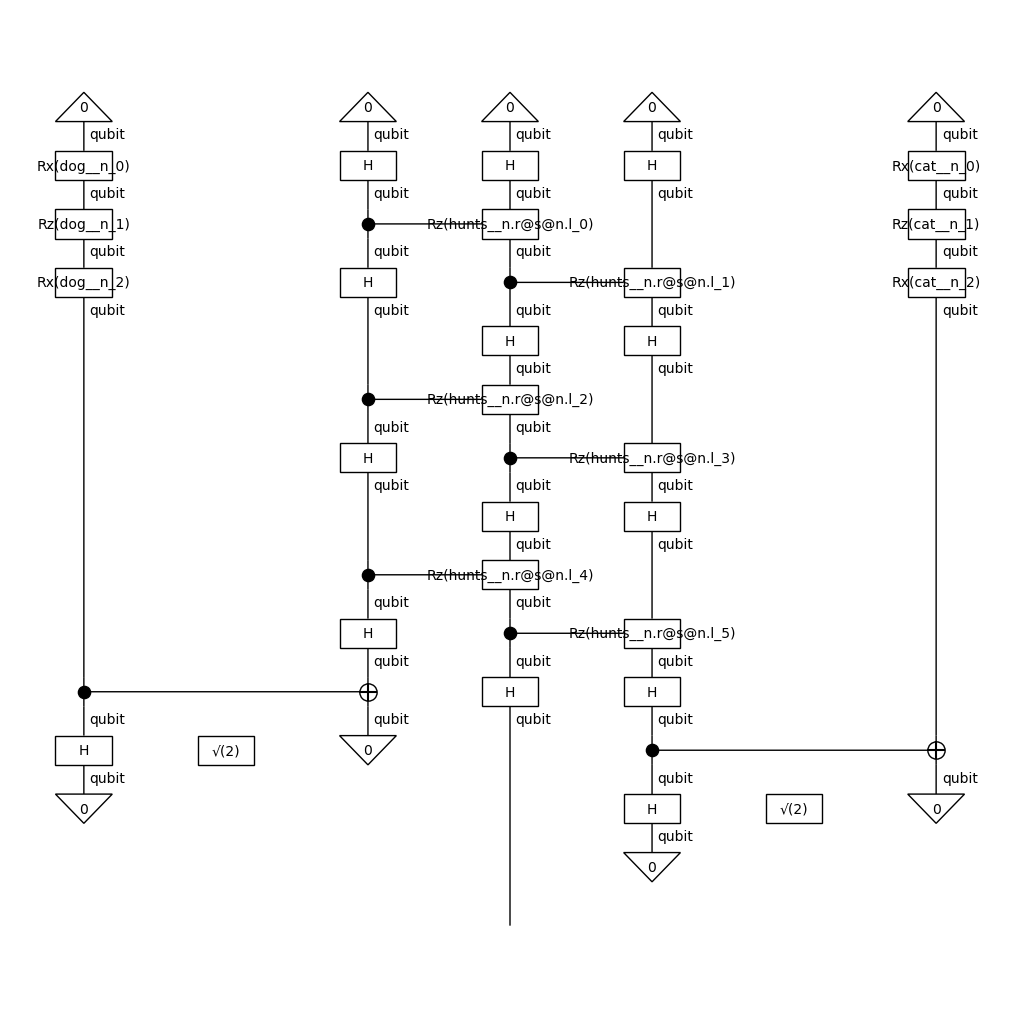

In [ ]:
#  construct the circuit in qiskit 

catHuntsDog = 'dog hunts cat'
# testSentence2 = 'cat is fast'

catHuntsDogDiag = parser.sentence2diagram(catHuntsDog)

CHDcircuit = ansatz(catHuntsDogDiag)

CHDcircuit.draw(figsize = (10,10))

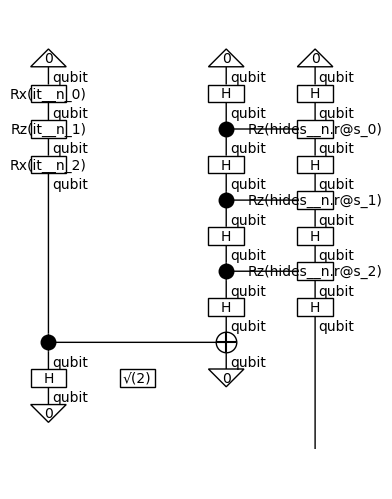

In [ ]:
# now, it hides circuit 
itHides = 'it hides'
# testSentence2 = 'cat is fast'

itHidesDiag = parser.sentence2diagram(itHides)

itHidescircuit = ansatz(itHidesDiag)

itHidescircuit.draw()

tketCirc = itHidescircuit.to_tk()


In [ ]:
itHidesTketCirc = itHidescircuit.to_tk()

catHuntsDogTket = CHDcircuit.to_tk()

from pytket.extensions.qiskit import tk_to_qiskit

iHQiskit = tk_to_qiskit(itHidesTketCirc)
cHDQiskit = tk_to_qiskit(catHuntsDogTket)

# # iHQiskit.draw()
# cHDQiskit.draw()


In [ ]:
# add ccnot gates 

# add qubit 

from qiskit.circuit import ParameterVector, Parameter

def createCircuit(hunter, hunted, verb, measure: bool = False): 
    '''
    create circuit that describes probability distribution over composition methods 

    for the sentence 

    hunter hunts hunted. it verb
    '''
    qc = QuantumCircuit(9,1)

    thetaSubj1 = Parameter(str(hunter) + '0')
    thetaSubj2 = Parameter(str(hunter) + '1')
    thetaSubj3 = Parameter(str(hunter) + '2')

    thetaObj1 = Parameter(str(hunted) + '0')
    thetaObj2 = Parameter(str(hunted) + '1')
    thetaObj3 = Parameter(str(hunted) + '2')

    thetaHunts1 = Parameter('hunts0')
    thetaHunts2 = Parameter('hunts1')
    thetaHunts3 = Parameter('hunts2')
    thetaHunts4 = Parameter('hunts3')
    thetaHunts5 = Parameter('hunts4')
    thetaHunts6 = Parameter('hunts5')

    thetaVerb1  = Parameter(str(verb) + '0')
    thetaVerb2  = Parameter(str(verb) + '1')
    thetaVerb3  = Parameter(str(verb) + '2')

    qc.rx(thetaSubj1, 0)
    qc.rz(thetaSubj2, 0)
    qc.rx(thetaSubj3, 0)

    qc.rx(thetaObj1, 4)
    qc.rz(thetaObj2, 4)
    qc.rx(thetaObj3, 4)


    # copy object or subject 
    qc.x(5)
    # qc.h(5)
    qc.ccx(5, 0, 6)
    # qc.x(5)
    # qc.ccx(5, 4, 6)

    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.crz(thetaHunts1, 1,2)
    qc.crz(thetaHunts2, 2,3)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.crz(thetaHunts3, 1,2)
    qc.crz(thetaHunts4, 2,3)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.crz(thetaHunts5, 1,2)
    qc.crz(thetaHunts6, 2,3)
    qc.h(1)
    qc.h(2)
    qc.h(3)

    # now the verb part 

    qc.h(7)
    qc.h(8)
    qc.crz(thetaVerb1, 7, 8)
    qc.h(7)
    qc.h(8)
    qc.crz(thetaVerb2, 7, 8)
    qc.h(7)
    qc.h(8)
    qc.crz(thetaVerb3, 7, 8)
    qc.h(7)
    qc.h(8)

    # now, for the cups 
    qc.cx(7,8)
    qc.h(7)
    if measure: 
        qc.measure(7,0)
        qc.measure(8,0)

    qc.cx(0,1)
    qc.h(0)
    if measure:
        qc.measure(0,0)
        qc.measure(1,0)

    qc.cx(3,4)
    qc.h(3)
    if measure:
        qc.measure(3,0)
        qc.measure(4,0)
    

    params = qc.parameters


    # set the parameters of the remaining words based on the models weights 
    for i in range(len(params)):
        print(params[i])
        if str(params[i]) in parameterDict:

            # print('DEBUGDEBUGDEBUGDEBUG,  if we put in parameter ', parameterDict[str(params[i])], 'for the label: ', str(params[i]))
            qc = qc.assign_parameters({params[i]: (parameterDict[str(params[i])])})

    return qc

circuit = createCircuit('cat', 'spider', 'scares')




cat0
cat1
cat2
hunts0
hunts1
hunts2
hunts3
hunts4
hunts5
scares0
scares1
scares2
spider0
spider1
spider2


In [ ]:
import qiskit.quantum_info as qi 

# dM = qi.DensityMatrix.from_label('000000000')
# dM = dM.evolve(circuit)

rho = qi.DensityMatrix(circuit)

# measure the qubits and trace out the copying one 

rho.measure([0,1,2,3,4,6,7])

rho = qi.partial_trace(rho, [0,1,2,3,4,5,6,7])

# print(rho)
rho.draw('latex')

# print(qi.entropy(rho))

<IPython.core.display.Latex object>